# Linear Scaling

Linear scaling is ...
Activtion normalization layer ...
Initialized to standard deviations of data

In [20]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl
from gyoza.modelling import flow_layers as gmfl, losses as gml
from gyoza.tutorials import data_synthesis as gtds, plotting as gtp

from ipywidgets import interact, fixed
tf.keras.backend.set_floatx('float64')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from typing import List, Tuple, Generator, Callable

## Data Generation

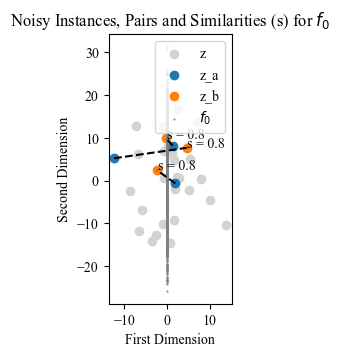

In [21]:
manifold_name = 'f_0'

# Generate points along a line
M = 2**12; N = 2 # Instance count, dimension count
gtds.reset_random_number_generators(seed=42) # Reproducability
S = np.random.normal(loc=0, scale=1.0, size=[M])

# Set up the raw manifold function
manifold_function = lambda S: (np.zeros(len(S)), S*8) # Move S to second dimension and stretch it

# Generate a dataset
noise_standard_deviation = [5.0, 0.0]
Z, Y = gtds.create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**5
target_correlations = [0.0, 0.8]
def synthesize_perfect_pairs(
    batch_size: int, 
    target_correlations: List[float], 
    manifold_function: Callable,
    noise_standard_deviation: List[float]
) -> Generator[Tuple[tf.Tensor, tf.Tensor], None, None]:
    """
    Infinite generator that synthesizes pairs by passing correlated latent 
    factors through a manifold function and adding Gaussian noise.
    """
    rho = np.array(target_correlations)
    n_std = np.array(noise_standard_deviation)
    dim_z = len(rho) # Total factors (e.g., 2)
    
    # Scale for conditional noise to maintain unit variance: sqrt(1 - rho^2)
    conditional_scale = np.sqrt(1.0 - np.square(rho))
    
    while True:
        # 1. Sample Correlated Latent Factors (Standard Normal)
        # z_a is the 'base' factor, z_b is the 'correlated' counterpart
        z_a = np.random.standard_normal(size=(batch_size, dim_z))
        epsilon = np.random.standard_normal(size=(batch_size, dim_z))
        z_b = rho * z_a + conditional_scale * epsilon
        
        # 2. Map through Manifold Function
        # We pass the semantic factor (index 1) to your function
        # z[:, 0] is the residual (mapped to 0 by your manifold_function)
        # z[:, 1] is the position S
        S_a, S_b = z_a[:, 1], z_b[:, 1]
        
        # Obtain 2D coordinates from manifold
        pos_a_x1, pos_a_x2 = manifold_function(S_a)
        pos_b_x1, pos_b_x2 = manifold_function(S_b)
        
        # Stack to form [batch_size, 2] tensors
        signal_a = np.stack([pos_a_x1, pos_a_x2], axis=1)
        signal_b = np.stack([pos_b_x1, pos_b_x2], axis=1)
        
        # 3. Add Observation Noise (Centered at 0)
        # Includes the residual noise (dim 0) and any jitter on dim 1
        jitter_a = np.random.normal(loc=0.0, scale=n_std, size=(batch_size, 2))
        jitter_b = np.random.normal(loc=0.0, scale=n_std, size=(batch_size, 2))
        
        X_a = signal_a + jitter_a
        X_b = signal_b + jitter_b
        
        # 4. Prepare Outputs
        Y_ab = np.repeat(rho[np.newaxis, :], repeats=batch_size, axis=0)
        
        yield (
            tf.cast(X_a, dtype=tf.keras.backend.floatx()), 
            tf.cast(X_b, dtype=tf.keras.backend.floatx())
        ), tf.cast(Y_ab, dtype=tf.keras.backend.floatx())


iterator = gtds.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)
#iterator = synthesize_perfect_pairs(batch_size=batch_size, 
#                                    target_correlations=target_correlations, 
#                                    manifold_function=manifold_function, 
#                                    noise_standard_deviation=noise_standard_deviation)

# Plot pairs of instances
(Z_a, Z_b), Y_ab  = next(iterator)
gtp.plot_instance_pairs(S=S, Z_a=Z_a, Z_b=Z_b, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)


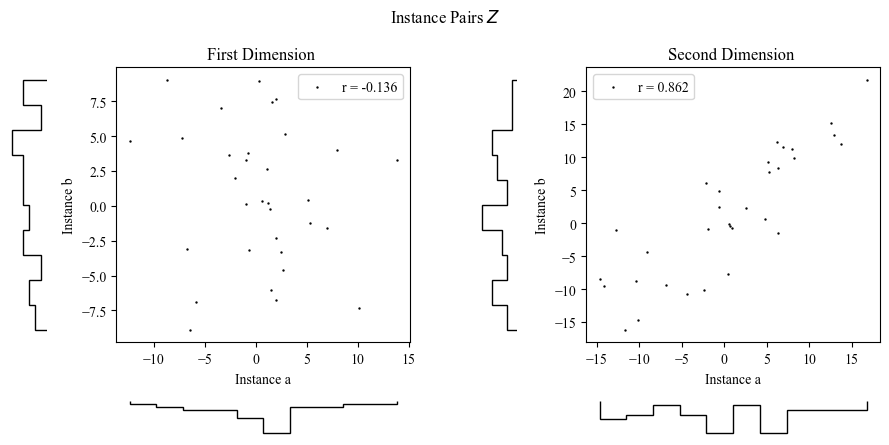

In [22]:
gtp.plot_instance_pairs_2(Z_a=Z_a, Z_b=Z_b)

## Model Creation

In [23]:
def create_model() -> gmfl.FlowModel:
    
    # Construct the network
    flow_model = gmfl.FlowModel(flow_layers=[gmfl.ActivationNormalization(axes=[1], shape=[N])]) # Essentially a keras Sequential model with the added benefit of computing the jacbian determinant and inverse of the overall flow
    flow_model.build(input_shape=[M, N]) # Pass a symbolic tensor through the model to help the tensorflow backend register all computations

    # Outputs
    return flow_model

# Reproducability
gtds.reset_random_number_generators(seed=123)

# Construct flow model
flow_model = create_model()
flow_model.summary()

# Inspect scaling parameter
print("Variable path: ", flow_model.variables[1].path)
print("Variable value: ", flow_model.variables[1].value.numpy(), " (default initialization of dimension 0 and 1, respectively)") # It is set to the standard deviation by default which is already optimal


Model: "flow_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ activation_normalization_2      │ [(None, 2), (None)]    │             4 │
│ (ActivationNormalization)       │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (32.00 B)

 Trainable params: 4 (32.00 B)

 Non-trainable params: 0 (0.00 B)

Variable path:  activation_normalization_2/_scale_
Variable value:  [1. 1.]  (default initialization of dimension 0 and 1, respectively)


In [24]:

# Plot input and output
#gtp.plot_input_output(flow_model, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)

## Model Training

In [25]:
# Reproducibility 
gtds.reset_random_number_generators(seed=123)

# Build a wrapper using tensorflow functional API
input_a = tf.keras.layers.Input(shape=(N,), name="z_a")
input_b = tf.keras.layers.Input(shape=(N,), name="z_b")

z_tilde_a, j_a = flow_model(input_a)
z_tilde_b, j_b = flow_model(input_b)
#j_a = flow_model.compute_jacobian_determinant(input_a)
#j_b = flow_model.compute_jacobian_determinant(input_b)

outputs = tf.keras.layers.Concatenate(axis=-1)([z_tilde_a, z_tilde_b, tf.keras.ops.reshape(j_a, (-1,1)), tf.keras.ops.reshape(j_b, (-1,1))]) # Concatenate them so they arrive as one 'y_pred' in the loss function
pair_model = tf.keras.Model(inputs=[input_a, input_b], outputs=outputs)

# Compile and Train
loss_function = gml.SupervisedFactorLoss(dimensions_per_factor=[1,1]) # 1 dimension for the residual factor, 1 for the position factor
#flow_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05), loss=loss_function)
pair_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=loss_function)
#tf.keras.utils.plot_model(pair_model, to_file='flow_model_graph.png', show_shapes=True)


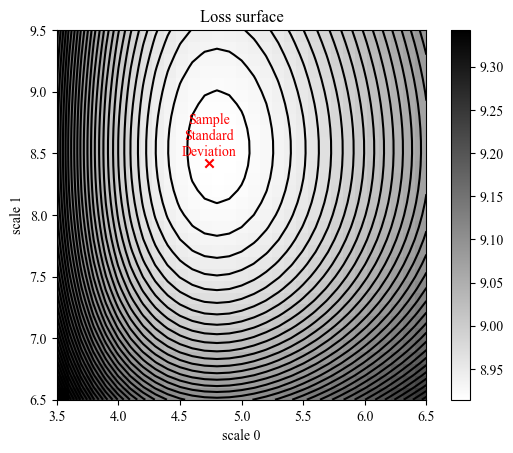

In [26]:
# Compute the loss surface
lb0, ub0, s0 = 3.5, 6.5, 0.1
lb1, ub1, s1 = 6.5, 9.5, 0.1
L = np.zeros([len(np.arange(lb0, ub0+s0 , s0)), len(np.arange(lb1, ub1+s1 , s1))])
std = np.array([0.0, 0.0])
loss_function = gml.SupervisedFactorLoss(dimensions_per_factor=[1,1]) # 1 dimension for the residual factor, 1 for the position factor

# Repeat a few times to average out noise inherent to the pair sampling procedure
repeats = 5
for r in range(repeats):
    Z_a, Z_b = next(iterator)[0]
    for i, scale_0 in enumerate(np.arange(lb0, ub0+s0, s0)):
        for j, scale_1 in enumerate(np.arange(lb1, ub1+s1, s1)):
            # 1. Update weights
            flow_model.flow_layers[0]._scale_.assign([scale_0, scale_1])
            
            # 2. Manual Forward Pass (Bypasses the static Functional Graph)
            y_pred = pair_model([Z_a, Z_b])
            # 4. Compute Loss
            loss = tf.math.reduce_mean(loss_function(y_pred=y_pred, y_true=Y_ab))
            L[i,j] += loss /repeats
    std += np.std(tf.concat([Z_a, Z_b], axis=0), axis=0)/repeats 

# Plot
L = L.T
plt.figure(); plt.title('Loss surface')
plt.imshow(np.flipud(L), extent=[lb0,ub0,lb1,ub1], colorizer=mpl.colorizer.Colorizer(cmap='binary'))
plt.colorbar()
plt.contour(*np.meshgrid(np.arange(lb0, ub0+s0 , s0),np.arange(lb1, ub1+s1 , s1)),L, 50,colors='k')
plt.scatter(*std, marker='x', c='r'); plt.text(*np.round(std+[0,+0.06],3), s='Sample\nStandard\nDeviation', color='r', ha='center')
plt.gca().set_aspect('equal'); plt.xlabel("scale 0"); plt.ylabel("scale 1")

plt.show()

In [33]:
# Ensure scale starts out as suboptimal
flow_model.variables[1].assign([15.0, 18.0])
print("Variable path: ", flow_model.variables[1].path)
print("Variable value: ", flow_model.variables[1].value.numpy(), " (optimized scale parameters of dimension 0 and 1, respectively)")

# Calibrate network
epoch_count = 25
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="/Users/timdick/Documents/Software Development/gyoza_folder/gyoza/tensorboard_logs", 
    write_graph=True, 
    update_freq='epoch'
)
history = pair_model.fit(iterator, steps_per_epoch=50, epochs=epoch_count, callbacks=[tensorboard_callback])

# Plot input and output
gtp.plot_input_output(flow_model, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)

# Check scaling parameters after optimization
print("Variable path: ", flow_model.variables[1].path)
print("Variable value: ", flow_model.variables[1].value.numpy(), " (optimized scale parameters of dimension 0 and 1, respectively)")

Variable path:  activation_normalization_2/_scale_
Variable value:  [15. 18.]  (optimized scale parameters of dimension 0 and 1, respectively)
Epoch 1/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9338
Epoch 2/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.8188
Epoch 3/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.6959
Epoch 4/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.5710
Epoch 5/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.4437
Epoch 6/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2933
Epoch 7/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.1363
Epoch 8/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9886 
Epoch 9/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8015
Epoch 10/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6458
Epoch 11/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4616
Epoch 12/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3411
Epoch 13/5000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [28]:

import os
import tensorflow as tf
from datetime import datetime

# 1. Setup absolute path for Mac
project_log_dir = os.path.join("/Users/timdick/Documents/Software Development/gyoza_folder/gyoza/tensorboard_logs")
run_id = "pure_graph_" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_path = os.path.join(project_log_dir, run_id)

# 2. Get the "Concrete Function"
# This forces TensorFlow to trace the model math into a fixed graph
# We use [batch_size=1, N] for the trace
func = tf.function(lambda x: pair_model(x)).get_concrete_function(
    [tf.TensorSpec([1, N], tf.float32), tf.TensorSpec([1, N], tf.float32)]
)

# 3. Use the Summary Writer to export ONLY the graph
writer = tf.summary.create_file_writer(log_path)
with writer.as_default():
    # This writes the graph metadata without starting a profiler session
    tf.summary.graph(func.graph)
    writer.flush()
    writer.close()

print(f"Success! Graph exported to: {log_path}")


Success! Graph exported to: /Users/timdick/Documents/Software Development/gyoza_folder/gyoza/tensorboard_logs/pure_graph_20260114-181540


## Evaluation

In [29]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:] 
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
gtp.plot_instance_pairs_2(Z_ab=Z_tilde_ab)

NameError: name 'network' is not defined